In [2]:
import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import random

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

In [3]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    print(X_var.data.size())
    y_pred = model(X_var)
    print(y_pred.data.size())
    print(y_var.data.size())
    loss = torch.sum(y_pred.masked_select(y_var.type(cuda.ByteTensor)).squeeze())
    #loss = torch.mean(y_pred.gather(1, y_var.view(-1, 1)).squeeze())
    model.zero_grad()
    loss.backward()
    grad = X_var.grad.data
    print(grad.size())
    
    saliency = grad.abs().max(dim=1)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency[0].squeeze()

--- Config --- 
num_classes : 17
seed : 231
batch_size : 20
print_every : None
use_gpu : True
epochs : 10
num_train : 10
lr : 0.0001
dtype : <class 'torch.cuda.FloatTensor'>
num_val : 10

torch.Size([10, 3, 224, 224])
torch.Size([10, 17])
torch.Size([10, 17])
torch.Size([10, 3, 224, 224])
(3, 224, 224)


TypeError: Invalid dimensions for image data

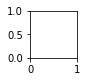

In [7]:
from torch.utils.data import DataLoader 
from torch import cuda, FloatTensor
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from resnetfinal import *
from utils import *

import argparse

class Config:
  def __init__(self):
    self.epochs = 10
    self.batch_size = 20
    self.lr = 1e-4
    self.num_train = 10
    self.num_val = 10
    self.print_every = None
    self.use_gpu = True
    self.dtype = cuda.FloatTensor if self.use_gpu else FloatTensor
    self.num_classes = 17
    self.seed = 231

  def __str__(self):
    properties = vars(self)
    properties = ["{} : {}".format(k, str(v)) for k, v in properties.items()]
    properties = '\n'.join(properties)
    properties = "--- Config --- \n" + properties + "\n"
    return properties

config = Config() 
print(config)

transform = transforms.Compose([
            transforms.CenterCrop(224)
        ])
train_dataset = NaiveDataset(TRAIN_DATA_PATH, TRAIN_LABELS_PATH, num_examples = NUM_TRAIN, transform=transform)
train_idx, val_idx = splitIndices(train_dataset, config, shuffle =False)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(train_dataset, batch_size = config.batch_size, num_workers = 3, sampler = train_sampler)
val_loader = DataLoader(train_dataset, batch_size = config.batch_size, num_workers = 1, sampler = val_sampler)

config.train_loader = train_loader
config.val_loader = val_loader

# Create Model
model = ResNet()
if config.use_gpu:
    model = model.cuda()
checkpoint = torch.load('experiments/resnet_conv2/checkpoints/best_model.ckpt')
model.load_state_dict(checkpoint['state_dict'])

class_names = ['agriculture',
        'artisinal_mine',
        'bare_ground',
        'blooming',
        'blow_down',
        'clear',
        'cloudy',
        'conventional_mine',
        'cultivation',
        'habitation',
        'haze',
        'partly_cloudy',
        'primary',
        'road',
        'selective_logging',
        'slash_burn',
        'water']
for t, (x, _, y) in enumerate(train_loader):
    #x = x.numpy()
    #y = y.numpy()
    #print(type(x))
    x = x.type(cuda.FloatTensor)
    y = y.type(cuda.FloatTensor)
    saliency = compute_saliency_maps(x, y, model)
    saliency = saliency.cpu().numpy()
    x = x.cpu().numpy()
    N = x.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        print(x[i].shape)
        plt.imshow(x[i])
        plt.axis('off')
        plt.title(" ".join([class_names[j] for j in y[i] if j != 0]))
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()